In [2]:
# implementation of probabilistic matrix factorisation

%load_ext autoreload
%autoreload 2

from utils import *

import pickle
import random
import numpy as np
from scipy.sparse import csr_matrix, save_npz, load_npz
from tqdm.notebook import tqdm
from itertools import chain
from collections import Counter, defaultdict
from pathlib import Path
from sklearn import metrics
import csv
import tensorflow as tf
import math
import matplotlib.pyplot as plt

/home/lucastong/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lucastong/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lucastong/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lucastong/.local/lib/python3.6/site-packages/tensorflow/python/framework/dty

In [3]:
np.set_printoptions(edgeitems=10)
np.core.arrayprint._line_width = 180

In [4]:
movieid_mid_lookup = get_movieid_mid_lookup(recompute=False)

In [8]:
# tags = set()
# max_tag, min_tag = 0, math.inf

# with open(movie_review_relevance, newline="") as csvfile:
#     reader = csv.DictReader(csvfile)
#     for rating in tqdm(reader):
# #         movieid = int(float(rating["movieId"]))
#         tagid = int(float(rating["tagId"]))
# #         relevance = float(rating["relevance"])
#         tags.add(tagid)
#         max_tag = max(max_tag, tagid)
#         min_tag = min(min_tag, tagid)

movie_tag_mids, movie_tag_relevances = get_raw_tag_relevances()
print(len(movie_tag_mids))

loading movie tags from csv


11709768it [01:08, 171194.21it/s]


10381


In [15]:
# the model

embedding_dim = 40
assert embedding_dim > 20

movie_tag_relevances_var = tf.placeholder(dtype=tf.float64, shape=[None, NUM_TAGS])

W1 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[NUM_TAGS, 5000], dtype=tf.float64))
b1 = tf.Variable(initial_value=np.zeros(shape=[5000], dtype=np.float64))
l1 = tf.nn.relu(tf.matmul(movie_tag_relevances_var, W1) + b1)

W2 = tf.Variable(tf.contrib.layers.xavier_initializer()(shape=[5000, NUM_TAGS], dtype=tf.float64))
b2 = tf.Variable(initial_value=np.zeros(shape=[NUM_TAGS], dtype=np.float64))
pred_y = tf.nn.sigmoid(tf.matmul(l1, W2) + b2)

print(movie_tag_relevances_var.shape, pred_y.shape)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

(?, 1128) (?, 1128)


In [16]:
train_relevances = movie_tag_relevances[1000:]
val_relevances = movie_tag_relevances[:1000]
print("num training examples", len(train_relevances))

plot_weights = True

learning_rate=.01
epochs=60

mse_loss_term = tf.reduce_mean(tf.squared_difference(pred_y, movie_tag_relevances_var))
loss = mse_loss_term

train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in tqdm(range(epochs), leave=False):
        val_loss_val = sess.run(loss, feed_dict={movie_tag_relevances_var: val_relevances})
        print("training")
        _, val_loss = sess.run((train_step, loss), feed_dict={movie_tag_relevances_var: train_relevances})
        print("train loss", val_loss)
#         print("l1 weights", sess.run(W4, feed_dict={movie_tag_relevances_var: train_relevances}))

        val_loss_val = sess.run(loss, feed_dict={movie_tag_relevances_var: val_relevances})

        print("val loss", val_loss_val)
        print("true", val_relevances[0])
        print("pred", sess.run(pred_y[0], feed_dict={movie_tag_relevances_var: val_relevances}))
        print("")

num training examples 9381


training
train loss 0.17274883105558303
val loss 0.048175727233211244
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [1.98001133e-09 2.42567593e-09 1.92189762e-09 1.99368831e-09
 4.70511978e-09 3.33418693e-09 6.21247592e-09 5.52579411e-09
 8.81433618e-10 4.40224616e-10 ... 1.19704135e-09 8.07589676e-10
 1.21636765e-09 3.10744553e-09 1.02427044e-08 1.57594173e-09
 1.24971828e-09 4.47926206e-09 5.11551599e-09 2.26704748e-09]

training
train loss 0.0356349633305217
val loss 0.048280440413099965
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [2.03416495e-24 2.95127287e-24 2.36816081e-24 3.28005063e-24
 1.76292626e-23 7.34721158e-24 1.75761712e-23 2.21748894e-23
 9.44985123e-25 2.52978265e-25 ... 1.50044527e-24 6.21969299e-25
 1.094383

pred [6.03098829e-198 3.48954530e-197 8.92741335e-197 1.16150167e-194
 4.10961255e-191 2.88816306e-194 8.86230603e-194 3.46425872e-191
 5.02577680e-196 9.67594360e-199 ... 1.36956825e-195 2.81175030e-198
 1.08363351e-197 3.90604538e-196 4.93276234e-185 5.75795614e-196
 2.36617928e-198 3.31065482e-195 3.08507818e-192 6.53767991e-198]

training
train loss 0.03597500513434896
val loss 0.04828044076052047
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [3.60287987e-206 2.21190681e-205 6.05276256e-205 9.88857697e-203
 4.60780446e-199 2.37763499e-202 7.19267572e-202 3.75841890e-199
 4.05340103e-204 6.32718806e-207 ... 1.11661156e-203 1.78871613e-206
 7.05916537e-206 2.67702800e-204 9.52147763e-193 4.37541031e-204
 1.42741724e-206 2.39324800e-203 3.00646740e-200 3.79859807e-206]

training
train loss 0.03597500513434896
val loss 0.04828044076052047
true [0.04575 0.05

training
train loss 0.03597500513434896
val loss 0.04828044076052047
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [5.25165703e-272 5.13988929e-271 2.44956218e-270 2.52369010e-267
 1.02447179e-262 4.41445394e-267 1.15401146e-266 6.31065742e-263
 7.00977080e-269 2.10324408e-272 ... 2.06652694e-268 4.55133528e-272
 2.13705416e-271 1.14727825e-269 1.59027292e-254 4.52002186e-269
 2.31726128e-272 1.53501709e-268 2.12147115e-264 4.32483466e-272]

training
train loss 0.03597500513434896
val loss 0.04828044076052047
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [2.45898343e-274 2.44619727e-273 1.18943630e-272 1.30866967e-269
 5.72903552e-265 2.26036175e-269 5.87322483e-269 3.49263443e-265
 3.58957405e-271 1.01677273e-274 ... 1.06022829

pred [2.45406888e-291 2.74865870e-290 1.54873005e-289 2.75584967e-286
 2.08980843e-281 4.32931942e-286 1.07438787e-285 1.18009949e-281
 6.91274370e-288 1.28764652e-291 ... 2.06804907e-287 2.54380098e-291
 1.25070993e-290 7.31413206e-289 1.14464374e-272 3.79065147e-288
 1.12695135e-291 1.09444463e-287 3.06785608e-283 1.86584613e-291]

training
train loss 0.03597500513434896
val loss 0.04828044076052047
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [5.54884501e-292 6.24291575e-291 3.53743402e-290 6.41089140e-287
 4.96376847e-282 1.00341298e-286 2.48563661e-286 2.79477245e-282
 1.60277743e-288 2.93843948e-292 ... 4.79710253e-288 5.78685096e-292
 2.84951094e-291 1.67097364e-289 2.83567477e-273 8.74079072e-289
 2.55168102e-292 2.50959078e-288 7.20313326e-284 4.20735307e-292]

training
train loss 0.03597500513434896
val loss 0.04828044076052047
true [0.04575 0.05

training
train loss 0.03597500513434896
val loss 0.04828044076052047
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [9.40456464e-297 1.09378305e-295 6.46172545e-295 1.34092031e-291
 1.21083972e-286 2.04182311e-291 4.99034128e-291 6.67036669e-287
 3.27185869e-293 5.33377304e-297 ... 9.82441674e-293 1.02617062e-296
 5.10923013e-296 3.05682781e-294 9.44150142e-278 1.71300733e-293
 4.37018312e-297 4.71742436e-293 1.61302513e-288 6.98790632e-297]

training
train loss 0.03597500513434896
val loss 0.04828044076052047
true [0.04575 0.05275 0.16675 0.08275 0.1145  0.15625 0.05025 0.11175 0.0395
 0.08    ... 0.0375  0.02825 0.012   0.03575 0.13    0.04875 0.01975
 0.0105  0.10925 0.0185 ]
pred [6.59279649e-297 7.67587634e-296 4.54080374e-295 9.46439398e-292
 8.58887713e-287 1.43985273e-291 3.51754304e-291 4.72815806e-287
 2.30751874e-293 3.74744319e-297 ... 6.92949623

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

train_relevances = movie_tag_relevances[1000:]
val_relevances = movie_tag_relevances[:1000]

scaler = StandardScaler()
scaler.fit(train_relevances)
# Apply transform to both the training set and the test set.
train_relevances = scaler.transform(train_relevances)
val_relevances = scaler.transform(val_relevances)

[0.6, 0.7, 0.8, 0.82, 0.83, 0.835, 0.84, 0.8425, 0.845, 0.8475, 0.85]



[(0.6, 58, 0.3996696953810888), (0.7, 121, 0.2993486543378872), (0.8, 239, 0.1999324821475713), (0.82, 273, 0.17949590379369446), (0.83, 291, 0.1696365750374688), (0.835, 300, 0.1649158054182194), (0.84, 310, 0.1598198901090493), (0.8425, 315, 0.15733785103121956), (0.845, 320, 0.15489535392516116), (0.8475, 325, 0.1524951866128128), (0.85, 331, 0.1496720729276908)]


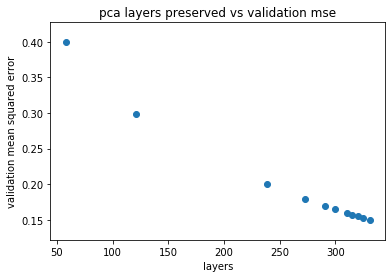

In [15]:
variances = [.6, .7, .8, .82, .83, .835, .84, .8425, .845, .8475, .85]
print(variances)
dimensions = []
val_mses = []

for variance in tqdm(variances):
    model = PCA(variance).fit(train_relevances)

    reduced_train_relevances = model.transform(train_relevances)
    pred_train_relevances = model.inverse_transform(reduced_train_relevances)

    reduced_val_relevances = model.transform(val_relevances)
    pred_val_relevances = model.inverse_transform(reduced_val_relevances)
    dimensions.append(reduced_val_relevances.shape[1])

    val_mse = np.mean((pred_train_relevances - train_relevances)*(pred_train_relevances - train_relevances))
    val_mses.append(val_mse)
#     print(np.mean((pred_val_relevances - val_relevances)*(pred_val_relevances - val_relevances)))

print(list(zip(variances, dimensions, val_mses)))

plt.xlabel("layers")
plt.ylabel("validation mean squared error")
plt.scatter(dimensions, val_mses)
plt.title("pca layers preserved vs validation mse")
plt.savefig("graphs/pca_layers_mse.png")

# use 0.96875 as variance

In [125]:
# use pca to reduce dimensions with preserved_variance=0.96875 => dim=768 (reduction by 32%), val mse=0.031122472 on scaled data
preserved_variance = 0.90

user_Xs, movie_Xs, ys = get_dataset(train_set, include_ys=True, recompute=False)
train_tags = get_tags(movie_Xs, preserved_variance, recompute=False)

NUM_PROJ_TAGS = train_tags[0].shape[0]
print(f"projected down to {NUM_PROJ_TAGS} dims from {NUM_TAGS} dimensions (reduced by {1-NUM_PROJ_TAGS/NUM_TAGS})")

retrieving dataset from dataset/train_ratings_binary.csv







  0%|          | 0/11946576 [00:00<?, ?it/s]




  2%|▏         | 183789/11946576 [00:00<00:06, 1837882.99it/s]

getting tags







  3%|▎         | 361784/11946576 [00:00<00:06, 1820110.15it/s]




  5%|▍         | 555618/11946576 [00:00<00:06, 1854035.71it/s]




  6%|▋         | 768791/11946576 [00:00<00:05, 1929436.41it/s]




  8%|▊         | 991834/11946576 [00:00<00:05, 2010843.89it/s]




 10%|█         | 1216466/11946576 [00:00<00:05, 2076133.87it/s]




 12%|█▏        | 1448569/11946576 [00:00<00:04, 2143998.20it/s]




 14%|█▍        | 1682314/11946576 [00:00<00:04, 2198585.06it/s]




 16%|█▌        | 1915328/11946576 [00:00<00:04, 2236462.47it/s]




 18%|█▊        | 2152182/11946576 [00:01<00:04, 2274510.25it/s]




 20%|██        | 2390663/11946576 [00:01<00:04, 2306511.24it/s]




 22%|██▏       | 2628199/11946576 [00:01<00:04, 2326742.15it/s]




 24%|██▍       | 2870993/11946576 [00:01<00:03, 2356201.89it/s]




 26%|██▌       | 3115226/11946576 [00:01<00:03, 2381394.68it/s]




 28%|██▊       | 3352548/11946576 [00:02<00:11, 767753.30it/s] 




 30%|██▉       | 3527598/11946576 [00:02<00:09,

projected down to 646 dims from 1128 dimensions (reduced by 0.4273049645390071)


In [4]:
print(train_tags[:5])


[array([0.19499993, 0.26932433, 0.16548704, 0.30513933, 0.25957322,
       0.31468445, 0.21783373, 0.33380088, 0.32604718, 0.35116148,
       0.24623372, 0.2825228 , 0.27335486, 0.3139616 , 0.3031217 ,
       0.24353845, 0.22127065, 0.2964685 , 0.2799396 , 0.2585362 ,
       0.29813728, 0.25344273, 0.31887996, 0.32067055, 0.27661493,
       0.31390274, 0.2841844 , 0.34395897, 0.30886206, 0.3419188 ,
       0.28596923, 0.3058844 , 0.3279011 , 0.2711107 , 0.27848014,
       0.26054803, 0.29566747, 0.2884222 , 0.32165137, 0.29650766,
       0.30496567, 0.2861339 , 0.28910568, 0.27990335, 0.28922498,
       0.27595046, 0.29772282, 0.28098527, 0.29738665, 0.29211843,
       0.29760945, 0.26875883, 0.2808908 , 0.3021804 , 0.30604818,
       0.283767  , 0.31507048, 0.2733025 , 0.30144453, 0.26626727,
       0.2735752 , 0.2790814 , 0.26703948, 0.29587737, 0.3031414 ,
       0.30196437, 0.30051717, 0.301843  , 0.29942873, 0.30721503,
       0.27768773, 0.29579383, 0.29635638, 0.31578767, 0.2826

print("counting movie percentage that straight up have no tags/movies with at least 1 tag with 0 relevance/total movies")

at_least_a_0 = []
all_0s = []
for i, row in enumerate(tqdm(movie_tag_relevances)):
    if 0 in row:
        at_least_a_0.append(i)
        if sum([1 for e in row if e == 0]) == NUM_TAGS:
            all_0s.append(i)
print("total movies", i+1)
print("movies with at least 1 irrelevant tag", len(at_least_a_0))
print("movies with no tags", len(all_0s))

# CONCLUSION: IF A MOVIE HAS AT LEAST ONE TAG WITH 0 RELEVANCE, THAT MOVIE HAS NO TAG INFO

movies_with_missing_tags = set(get_movies_with_missing_tags())
movieid_mid_lookup = get_movieid_mid_lookup()

def count_na(filename):
    print("counting movie records (will have more movie records than straight up movies) that don't have any tags")
    na_ct, valid_ct = 0, 0
    with open(filename, newline="") as csvfile:
        reader = csv.DictReader(csvfile)
        for rating in tqdm(reader):
            movieid = int(float(rating["movieId"]))
            if movieid_mid_lookup[movieid] in movies_with_missing_tags:
                na_ct += 1
            else:
                valid_ct += 1
    return na_ct, valid_ct

na_ct, valid_ct = count_na(movie_review_relevance)
print(na_ct/(na_ct+valid_ct), " movie_review_relevance entries have no tag info")
na_ct, valid_ct = count_na(movie_genres)
print(na_ct/(na_ct+valid_ct), " movie_genres entries have no tag info")
na_ct, valid_ct = count_na(train_set)
print(na_ct/(na_ct+valid_ct), " train_set entries have no tag info")
na_ct, valid_ct = count_na(val_set)
print(na_ct/(na_ct+valid_ct), " val_set entries have no tag info")
na_ct, valid_ct = count_na(test_set)
print(na_ct/(na_ct+valid_ct), " test_set entries have no tag info")

# CONCLUSION: 61.9% OF ALL MOVIES DON'T HAVE ANY TAG INFO BUT MOST MOVIES THAT ARE FREQUENTLY WATCHED HAVE FULL TAG INFO - ONLY ~3% OF TEST SET MOVIE WATCH ENTRIES HAVE NO TAG INFO

In [51]:
# just verifying the earlier tag analysis

movies_with_missing_tags = get_movies_with_missing_tags()
movieid_mid_lookup = get_movieid_mid_lookup()
movie_tags = np.zeros((NUM_MOVIES, NUM_TAGS), dtype=np.float32)

with open(movie_review_relevance, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        movieid = int(float(rating["movieId"]))
        tagid = int(float(rating["tagId"]))
        relevance = float(rating["relevance"])

        mid = movieid_mid_lookup[movieid]
        tid = tagid_to_tid(tagid)
        movie_tags[mid, tid] = relevance
        if mid in movies_with_missing_tags:
            print(mid, tid, relevance)
            
# conclusion: yeah no tags in movies_with_missing_tags have any tag information - they're not just a bunch of literal 0s in the dataset

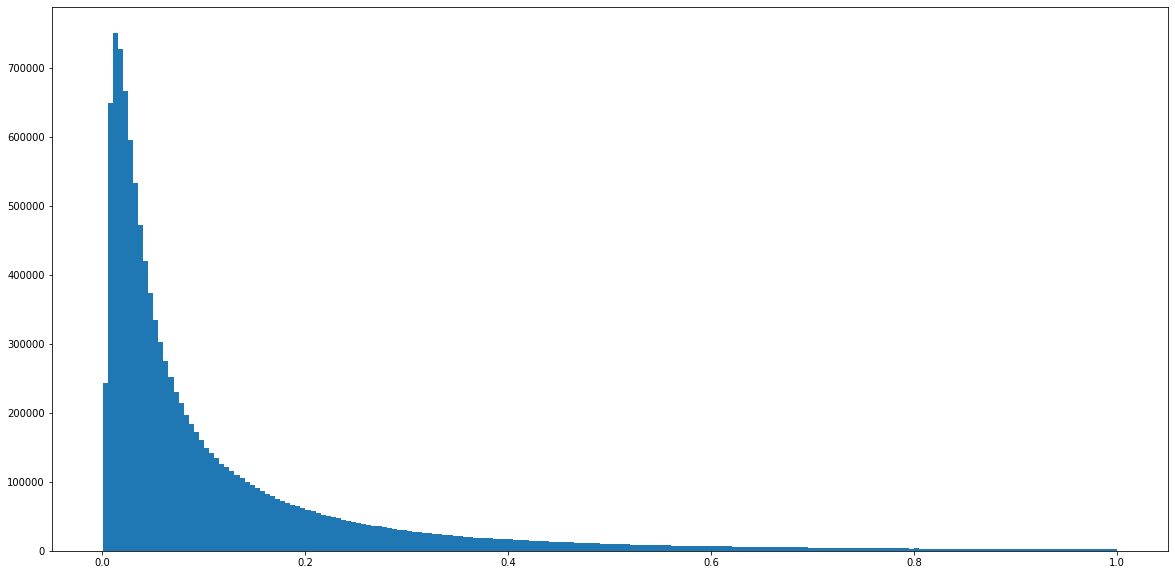

In [19]:
plt.rc('figure', figsize=(20, 10))
plt.hist(movie_tag_relevances.flatten(), bins=200)
plt.show()

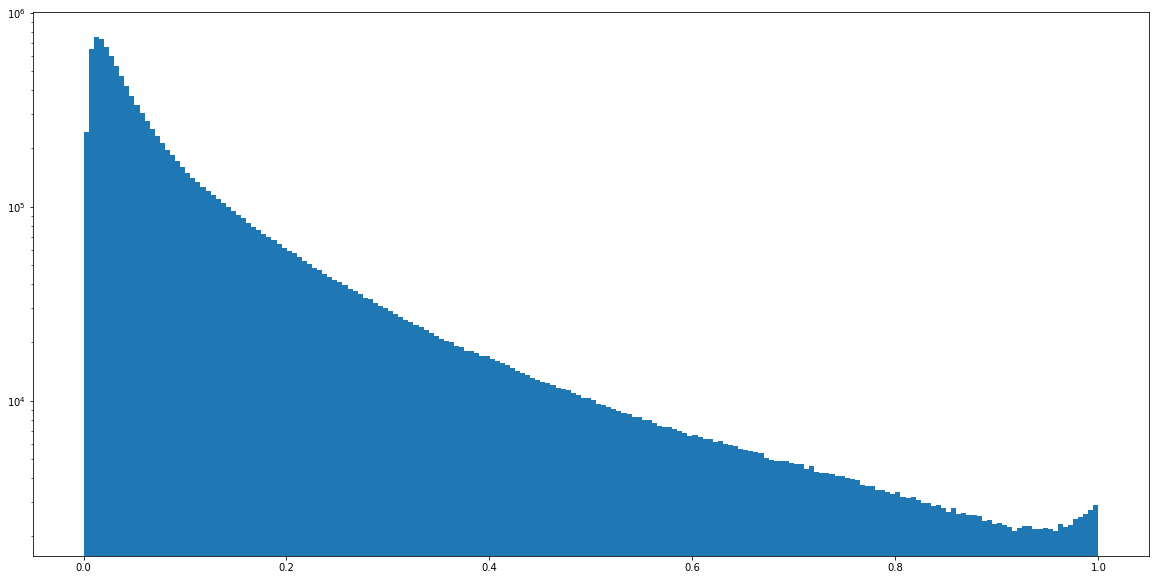

In [20]:
plt.hist(movie_tag_relevances.flatten(), bins=200, log=True)
plt.show()

33414 tags more relevant than .95


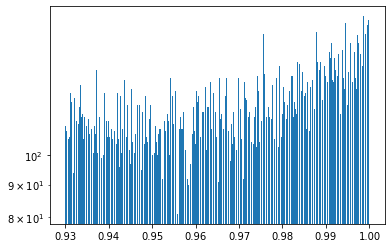

In [31]:
very_relevant = [i for i in movie_tag_relevances.flatten() if i > .93]
print(len(very_relevant), "tags more relevant than .95")
plt.hist(very_relevant, bins=400, log=True)
plt.show()

In [26]:
from collections import defaultdict
cutoff = .95
counts = defaultdict(lambda: 0)

for row in movie_tag_relevances:
    count = len([i for i in row if i > cutoff])
    counts[count] += 1
print(counts)

defaultdict(<function <lambda> at 0x7f95346a7840>, {3: 1205, 17: 3, 2: 1830, 9: 108, 18: 7, 10: 63, 16: 12, 11: 54, 13: 15, 5: 568, 15: 8, 4: 861, 25: 1, 6: 361, 7: 238, 8: 147, 0: 2588, 1: 2261, 22: 2, 19: 3, 14: 12, 12: 29, 23: 2, 21: 2, 20: 1})


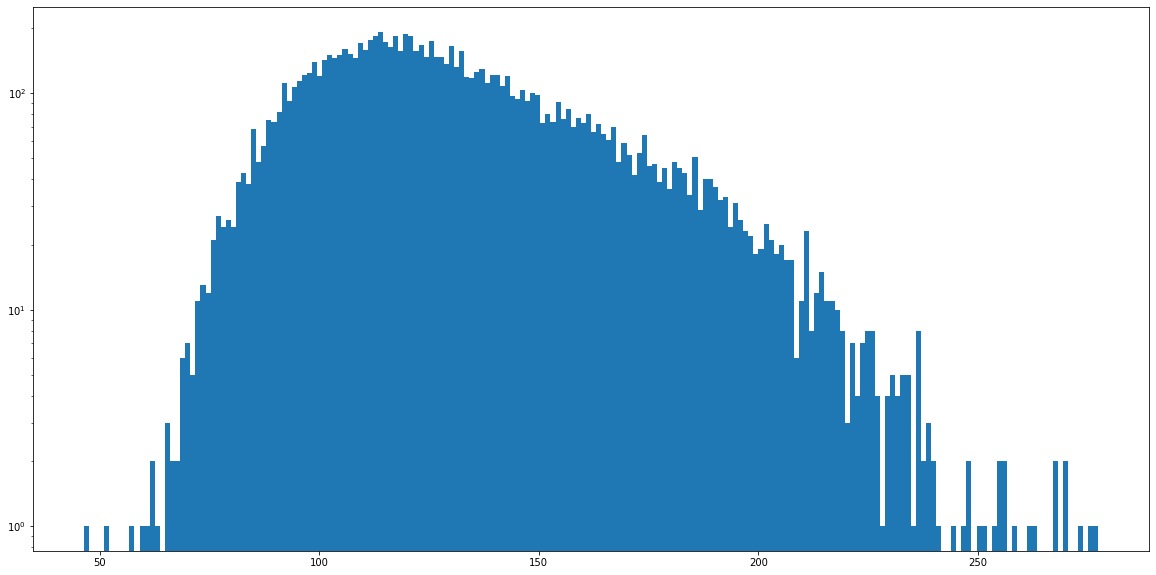

In [21]:
plt.hist([sum(i) for i in movie_tag_relevances], bins=200, log=True)
plt.show()

movies_with_missing_tags = set(get_movies_with_missing_tags())

liked = 0
disliked = 0

with open(train_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        movieid = int(float(rating["movieId"]))
        
        if movieid_mid_lookup[movieid] in movies_with_missing_tags:
            if rating["rating"] == "1":
                liked += 1
            else:
                disliked += 1

print(liked, disliked)

# 31.2962495% of movies with no tag information will be disliked

encountered_users = []

with open(train_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        userid = int(float(rating["userId"]))
        encountered_users.append(userid)

with open(val_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        userid = int(float(rating["userId"]))
        encountered_users.append(userid)

encountered_users = set(encountered_users)

with open(test_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        userid = int(float(rating["userId"]))
        if userid not in encountered_users:
            print(f"USERID {userid} NOT ENCOUNTERED IN TRAIN SET BUT IN TEST SET")
            
# all users will have been seen before by training or validation sets.

movieid_mid_lookup = get_movieid_mid_lookup()
with open(test_set, newline="") as csvfile:
    reader = csv.DictReader(csvfile)
    for rating in tqdm(reader):
        movieid = int(float(rating["movieId"]))
        if movieid not in movieid_mid_lookup:
            print(f"MOVIEID {movieid} NOT ENCOUNTERED IN TRAIN SET BUT IN TEST SET")

# all movies will have been seen before by training or validation sets.

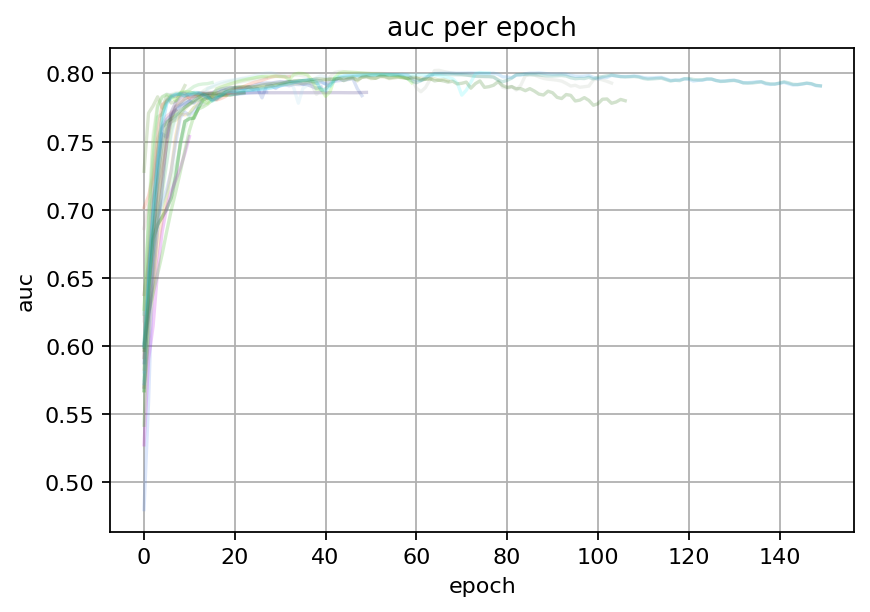

In [20]:
with open("prev_run_stats.pickle", "rb") as prev_run_file:
    cur_run, run_scores, best_auc, best_auc_run = pickle.load(prev_run_file)


plt.figure(dpi=160)

    
for val_accs, val_aucs in run_scores.values():
    plt.title("auc per epoch")
    plt.grid(True)
    plt.xlabel("epoch")
    plt.ylabel("auc")
    plt.plot(val_aucs, color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1), .2))

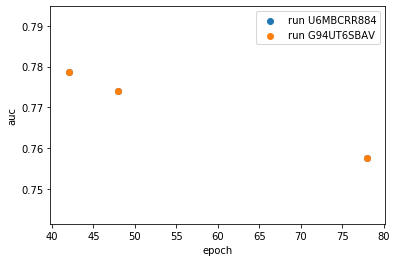

In [50]:
# plot epoch against test auc
test_epochs = [78, 42, 48]
test_aucs = [0.75760, 0.77855, 0.77397]
test_epochs, test_aucs = np.array(sorted(np.array([test_epochs, test_aucs]).T.tolist())).T
plt.scatter(test_epochs, test_aucs, label="run U6MBCRR884")

test_epochs = [78, 42, 48]
test_aucs = [0.75760, 0.77855, 0.77397]
test_epochs, test_aucs = np.array(sorted(np.array([test_epochs, test_aucs]).T.tolist())).T
plt.scatter(test_epochs, test_aucs, label="run G94UT6SBAV")
plt.xlabel("epoch")
plt.ylabel("auc")
plt.legend()
plt.show()

In [51]:
#! kaggle competitions submit -c uclacs145fall2019 -f models/G94UT6SBAV/ -m "trying to pinpoint epoch... trying 48"

basic_nn-Copy1.ipynb	     nn_test.py
basic_nn.ipynb		     ping_kaggle.py
content_based.py	     prev_run_stats.pickle
cur_train_loss.png	     probablistic_matrix_factorization_ml.ipynb
cur_val_aucs.png	     __pycache__
dataset			     README.md
graphs			     reduce_tag_dimensions.ipynb
hmmm.ipynb		     submission_info.pickle
logs			     tag_to_tid.pickle
mid_genres_one_hot.pickle    test_preds.csv
mid_to_proj_tag.pickle	     trivial.py
model_load_script.py	     Untitled1.ipynb
models			     Untitled2.ipynb
movieid_mid_lookup.pickle    Untitled3.ipynb
movie_tag_relevances.pickle  Untitled.ipynb
nn_brute_force_lmao.py	     utils.py
nn_dataset
